In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import fnmatch
import time
import func
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, train_csv_path, unseen_csv_path, unseen_root

In [4]:
train_db = pd.read_csv(train_csv_path)
unseen_db = pd.read_csv(unseen_csv_path)
real_model_list = train_db['brand_model']
unseen_model_list = unseen_db['brand_model']

# How many model in my dataset, real are trained models, test are unseen models
real_model = np.unique(real_model_list) 
unseen_model = np.unique(unseen_model_list) 
print("real models: {}".format(', '.join(real_model)))
print("test models: {}\n".format(', '.join(unseen_model)))

# get information about the test set of unseen experiment
if not os.path.exists(unseen_root):
    os.makedirs(unseen_root)
    time.sleep(0.3)
    for model in unseen_model:
        tmp_list = fnmatch.filter(unseen_db['path'], model + '*')
        print("{} in test set: {}.".format(model, len(tmp_list)))
        time.sleep(0.1)
        func.patch(model, tmp_list, '.', patches_root=unseen_root)
else:
    for model in unseen_model:
        tmp_list = fnmatch.filter(unseen_db['path'], model + '*')
        print("{} in test set: {}.".format(model, len(tmp_list)))
    print('\nData is ready!')

real models: Canon_Ixus70, Nikon_D200, Olympus_mju-1050SW
test models: Agfa_DC-830i, Canon_Ixus55, Canon_PowerShotA640, Nikon_D70, Sony_DSC-W170

Agfa_DC-830i in test set: 363.
Canon_Ixus55 in test set: 224.
Canon_PowerShotA640 in test set: 188.
Nikon_D70 in test set: 369.
Sony_DSC-W170 in test set: 405.

Data is ready!


Test models on these 5 cameras:
- **Agfa_DC-830i** (different brand, same content)
- **Canon_Ixus55** (same brand, same content)
- **Canon_Powershot64** (same brand, different content)
- **Nikon_D70** (same brand, same content)
- **Sony_W170** (different brand, different content)

Found 38725 images belonging to 5 classes.

It tooks 65 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Nikon_D200,Olympus_mju-1050SW
Agfa_DC-830i,936,552,7
Canon_Ixus55,925,0,6
Canon_PowerShotA640,761,12,0
Nikon_D70,357,1035,106
Sony_DSC-W170,1364,325,14


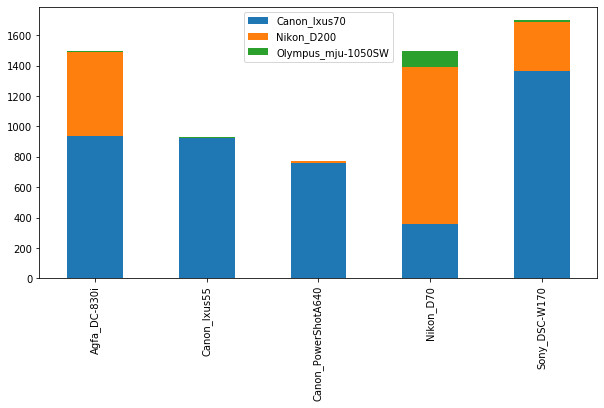

In [5]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./model.h5')
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)
# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./unseen/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# generate a histogram, which for every unseen models, how many imgs are classified.
hist, conf, pred_labels, real_labels = func.evaluate(unseen_model, test_generator, model, index=unseen_model, columns=real_model, title=None, num_batch=100)

The mean of the confidence is: 



,Canon_Ixus70,Nikon_D200,Olympus_mju-1050SW
Agfa_DC-830i,0.961886,0.937524,0.635921
Canon_Ixus55,0.999370,0.000000,0.966428
Canon_PowerShotA640,0.998464,0.920010,0.000000
Nikon_D70,0.899658,0.931398,0.745646
Sony_DSC-W170,0.972249,0.913527,0.773286


The standard deviation of the confidence is: 



,Canon_Ixus70,Nikon_D200,Olympus_mju-1050SW
Agfa_DC-830i,0.009123,0.014308,0.023072
Canon_Ixus55,0.000226,0.000000,0.001695
Canon_PowerShotA640,0.000456,0.017632,0.000000
Nikon_D70,0.019071,0.013874,0.025330
Sony_DSC-W170,0.006048,0.019168,0.016070


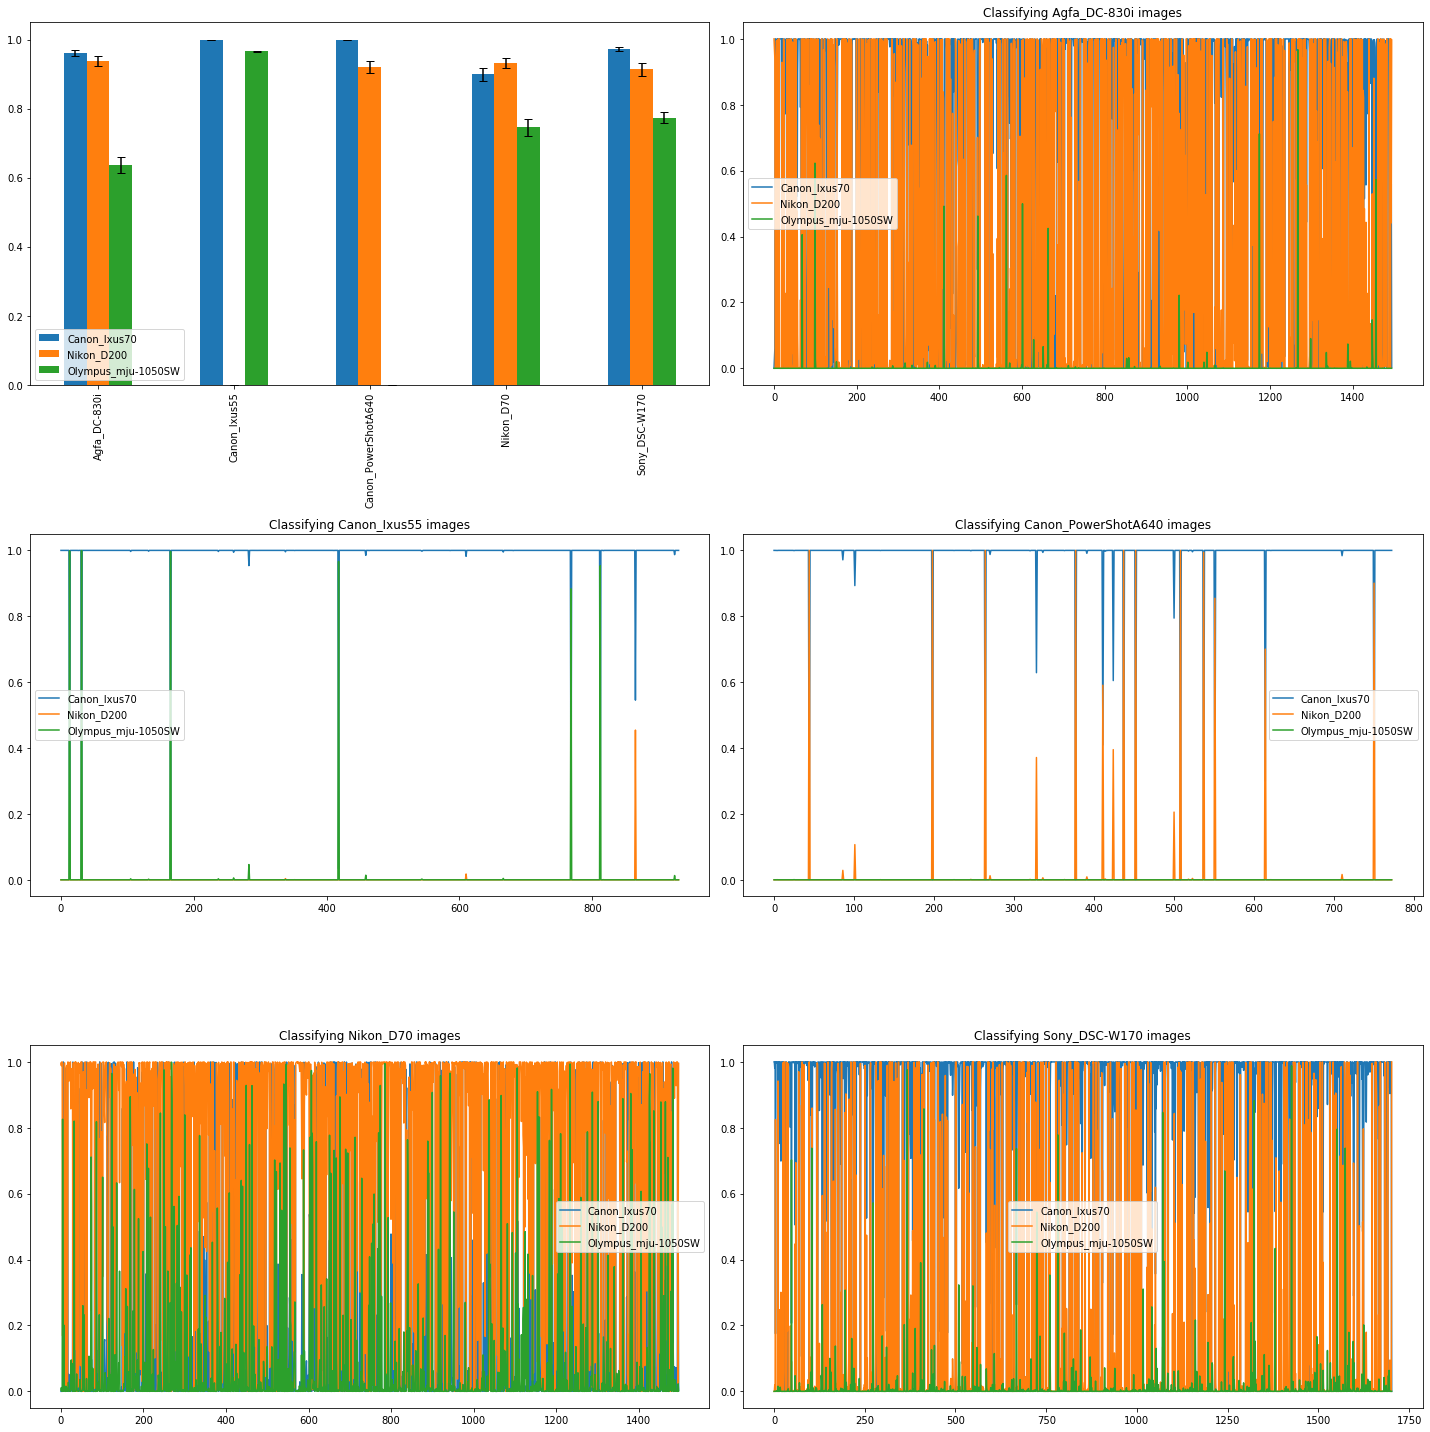

In [6]:
df_mean, df_error = func.mean_error(conf, pred_labels, real_labels,
                                    real_model=unseen_model, pred_model=real_model)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
df_mean.plot.bar(yerr=df_error, ax=axes[0,0], capsize=4)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1], 3:axes[2, 0], 4:axes[2, 1]}

func.plot_conf(conf, pred_labels, real_labels, graph, real_model=unseen_model, pred_model=real_model)
plt.tight_layout()